In [ ]:
#Preprocessing
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
import h5py
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn3, venn3_circles
import pickle
import gzip
import pandas as pd
import requests
import openslide
from openslide.deepzoom import DeepZoomGenerator
from openslide import open_slide
import math
import pdb
import time
import os
import matplotlib.patches as mpatches
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K

tissue_types = ['Lung', 'Artery - Tibial', 'Heart - Left Ventricle', 'Breast - Mammary Tissue', 'Brain - Cerebellum', 'Pancreas', 'Testis', 'Liver', 'Ovary', 'Stomach']
genotypes_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/GenotypeFiles/phg000520.v2.GTEx_MidPoint_Imputation.genotype-calls-vcf.c1/parse_data/GTEx_Analysis_20150112_OMNI_2.5M_5M_450Indiv_chr1to22_genot_imput_info04_maf01_HWEp1E6_ConstrVarIDs_all_chrom_filered_maf_subset_individuals_44_tissues.hdf5'
expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_*_normalised_without_inverse_gene_expression.txt'
phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
lung_expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_{}_normalised_without_inverse_gene_expression.txt'.format("Lung")

def build_empty_model():
    inception_model = InceptionV3(weights='imagenet', include_top=False)

    x = inception_model.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(input=inception_model.input, output=predictions)
    return model

def get_donor_IDs(IDlist):
    return [str(x).split('-')[1] for x in IDlist]

# Load lung data, generate and aggregate representations

In [1]:
data_tile_number = 10
data_tile_level_index = -1
t = "Lung"
[lung_X, tl, lung_ID] = pickle.load(open('../data/processed/patches/data_{}_{}_{}_check.py'.format(t,data_tile_number,data_tile_level_index), 'rb'))

# Generate representations

# Generate from scratch
model_tile_number = 50
model_tile_level_index = -1
model = build_empty_model()
model.load_weights('../models/inception_50_-1_gs1.h5')

final_layer_model = Model(model.input, model.layers[-2].output)
lung_full_representations = final_layer_model.predict(lung_X)

pickle.dump(lung_full_representations,open('../data/processed/representations/lung_representations_model_{}_{}_gs{}_data_{}_{}_check'.format(model_tile_number,model_tile_level_index,1,data_tile_number,data_tile_level_index), 'wb'))


lung_full_representations = pickle.load(open('../data/processed/representations/lung_representations_model_{}_{}_gs{}_data_{}_{}_check'.format(model_tile_number,model_tile_level_index,1,data_tile_number,data_tile_level_index), 'rb'))

# Aggregate representations

agg_lung_full_representations = []
for i in range(int(len(lung_full_representations) / 10)):
    reps_from_person = lung_full_representations[10*i:10*(i+1),:]
    agg_reps = np.mean(reps_from_person,axis=0)
    agg_lung_full_representations.append(agg_reps)
agg_lung_full_representations = np.array(agg_lung_full_representations)



# Load and filter expression data for Lung

In [ ]:


with open(lung_expression_filepath, 'r') as f:
    expression_table = np.array([x.split('\t') for x in f.read().splitlines()])

# These are the individual donor IDs from the RNA expression matrix
individual_lung_expression_donor_IDs = [x.split('-')[1] for x in expression_table[0,:][1:]]
print (len(individual_lung_expression_donor_IDs)) #278

# These are the individual donor IDs from the images.
individual_lung_image_donor_IDs = np.array(get_donor_IDs([lung_ID[data_tile_number*i] for i in range(int(len(lung_ID) / 10))]))
print (len(individual_lung_image_donor_IDs)) #96

# #However these image donors are not unique. I.e. there are multiple images per donor.
# print (len(np.unique(individual_lung_image_donor_IDs)), len(individual_lung_image_donor_IDs))

# # We however only want one image per donor, so we only select representations with unique donors.
# unique_image_ID_idx = np.unique(individual_lung_image_donor_IDs, return_index=True)[1]
# unique_agg_reps = agg_reps[unique_image_ID_idx]

# Filter image IDs to ones where RNA expression exists
rna_exists = np.array([x in individual_lung_expression_donor_IDs for x in individual_lung_image_donor_IDs])
print (sum(rna_exists)) #74
f_individual_lung_image_donor_IDs = individual_lung_image_donor_IDs[rna_exists]

#Find the unique indexes of these IDs in the individual donor IDs which correspond to a single aggregated representation.
f_individual_lung_IDs_reps_idx = np.unique([list(individual_lung_image_donor_IDs).index(x) for x in f_individual_lung_image_donor_IDs])
print (len(f_individual_lung_IDs_reps_idx)) #63

#Find the indexes of these IDs in the RNA expression
f_individual_lung_IDs_exp_idx = np.unique([list(individual_lung_expression_donor_IDs).index(x) for x in f_individual_lung_image_donor_IDs])
print (len(f_individual_lung_IDs_exp_idx)) #63

#Find the unique indexes of these IDs in the individual donor IDs which correspond to a single aggregated representation.
f_individual_lung_IDs_reps_idx = np.unique([list(individual_lung_image_donor_IDs).index(x) for x in f_individual_lung_image_donor_IDs])
print (len(f_individual_lung_IDs_reps_idx)) #57

#Find the indexes of these IDs in the RNA expression
f_individual_lung_IDs_exp_idx = np.unique([list(individual_lung_expression_donor_IDs).index(x) for x in f_individual_lung_image_donor_IDs])
print (len(f_individual_lung_IDs_exp_idx)) #57

#Extract the correct data from the expression matrix and the aggregate representations.
expression_matrix = expression_table[1:,1:].astype(np.float32)

f_agg_lung_full_representations = agg_lung_full_representations[f_individual_lung_IDs_reps_idx,:]
f_expression_matrix = expression_matrix[:,f_individual_lung_IDs_exp_idx].T
print (f_agg_lung_full_representations.shape, f_expression_matrix.shape) # (63, 1024) (63, 28683)


pickle.dump([f_expression_matrix, f_agg_lung_full_representations], open('../data/processed/associations/lung_associations_check.py','wb'))

# Perform association tests

In [66]:
import random

from lim.genetics import qtl
from lim.genetics.phenotype import NormalPhenotype

import logging
lim_logging = logging.getLogger('lim')
lim_logging.setLevel(logging.CRITICAL)
[X_matrix, y_pheno] = pickle.load(open('../data/processed/associations/lung_associations_check.py','rb'))
filter_limit = 1
filtered_indexes = np.mean(X_matrix, axis=0) > filter_limit
f_X_matrix = X_matrix[:,filtered_indexes]
print (f_X_matrix.shape)
shuffle = '1'
upper_limit = math.floor(f_X_matrix.shape[1] / 100) + 1

p_values = []
f_y_pheno = y_pheno[:,266].copy()
if shuffle == '1':
    random.shuffle(f_y_pheno)
    f_y_pheno_obj = NormalPhenotype(f_y_pheno)
else:
    f_y_pheno_obj = NormalPhenotype(f_y_pheno)
f_y_pheno_obj = NormalPhenotype(f_y_pheno)
for i in range(upper_limit):
    sm_X_matrix = f_X_matrix[:, 100*i:100*(i+1)]
    G = sm_X_matrix[:, 1:].copy()
#     print (f_X_matrix.shape, f_y_pheno.shape)

    lrt = qtl.scan(f_y_pheno_obj, sm_X_matrix, G, progress=False)
    p_values.extend(lrt.pvalues())
    if i % 10 == 0:
        print (i)

pickle.dump(p_values, open('../data/processed/associations/266_lung_p_values_check_shuffle{}_filterlimit{}_check.py'.format(shuffle,filter_limit),'wb'))

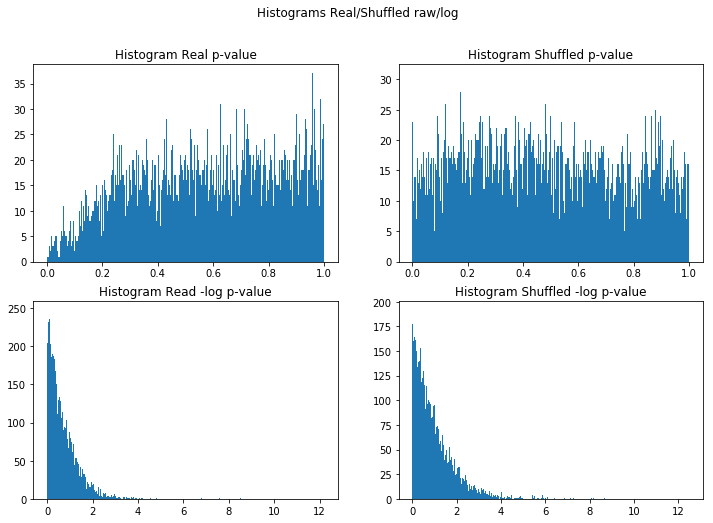

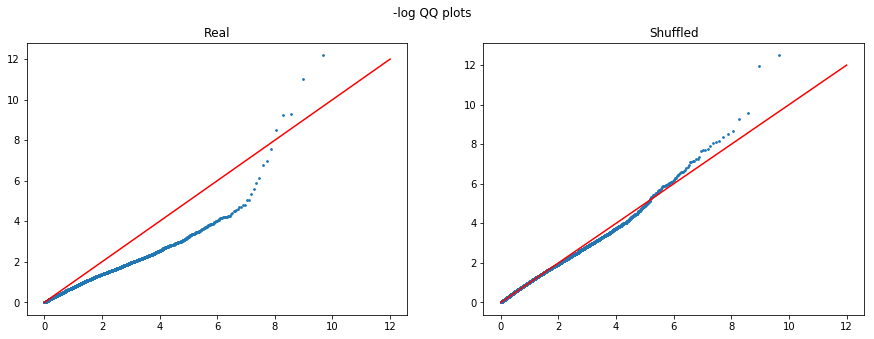

In [78]:

import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import pearsonr
%matplotlib inline

real_pvalues = np.array(pickle.load(open('../data/processed/associations/266_lung_p_values_check_shuffle0_filterlimit1_check.py','rb')))
shuffled_pvalues = np.array(pickle.load(open('../data/processed/associations/266_lung_p_values_check_shuffle1_filterlimit1_check.py','rb')))
[X_matrix, y_pheno] = pickle.load(open('../data/processed/associations/lung_associations.py','rb'))

f,a = plt.subplots(2,2, figsize=(12,8))
f.suptitle("Histograms Real/Shuffled raw/log")
a[0][0].set_title("Histogram Real p-value")
a[0][0].hist([x for x in real_pvalues],bins=1000)
a[0][1].set_title("Histogram Shuffled p-value")
a[0][1].hist([x for x in shuffled_pvalues],bins=1000)
a[1][0].set_title("Histogram Read -log p-value")
a[1][0].hist([-math.log(x) for x in real_pvalues],bins=1000)
a[1][1].set_title("Histogram Shuffled -log p-value")
a[1][1].hist([-math.log(x) for x in shuffled_pvalues],bins=1000)
plt.show()

sorted_real_indexes = np.argsort(real_pvalues)
sorted_real_pvalues = real_pvalues[sorted_real_indexes]
sorted_shuffled_indexes = np.argsort(shuffled_pvalues)
sorted_shuffled_pvalues = shuffled_pvalues[sorted_shuffled_indexes]


sample_real = sorted_real_pvalues
expected_real = np.linspace(1/len(sorted_real_pvalues), 1, len(sorted_real_pvalues))
sample_shuffle = sorted_shuffled_pvalues
expected_shuffle = np.linspace(1/len(sorted_shuffled_pvalues), 1, len(sorted_shuffled_pvalues))
# 
f,a = plt.subplots(1,2, figsize=(15,5))
f.suptitle('-log QQ plots')
a[0].scatter([-math.log(x) for x in expected_real], [-math.log(x) for x in sample_real], s=3)
a[0].plot(np.linspace(0,12,100), np.linspace(0,12,100),c='red')
a[0].set_title('Real')
a[1].scatter([-math.log(x) for x in expected_shuffle], [-math.log(x) for x in sample_shuffle], s=3)
a[1].plot(np.linspace(0,12,100), np.linspace(0,12,100),c='red')
a[1].set_title('Shuffled')
